# Data Prepare for PP OCR v5 detection

In [8]:
import os
import json
import random
import shutil
from pathlib import Path


In [9]:
# ================== CẤU HÌNH ==================

# Thư mục gốc dataset hiện tại (như bạn mô tả)
DATASET_ROOT = r"D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN"

# Thư mục mới để chứa dữ liệu dạng PaddleOCR
OUTPUT_ROOT = r"D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_det"

# Tỉ lệ train / val
TRAIN_RATIO = 0.8

# Seed cho random để chia train/val cố định
RANDOM_SEED = 42


In [10]:
def shape_to_quad_points(points, shape_type="polygon"):
    """
    Chuyển list points của LabelMe thành 4 điểm (quad).
    - Nếu 'rectangle' (2 điểm): dùng 2 điểm đối góc để tạo bbox.
    - Nếu polygon >= 4 điểm: lấy bbox bao ngoài (đơn giản, an toàn).
    Trả về list 4 điểm: [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    """
    if not points or len(points) < 2:
        return None

    if shape_type == "rectangle" or len(points) == 2:
        (x1, y1), (x2, y2) = points
        x_min, x_max = min(x1, x2), max(x1, x2)
        y_min, y_max = min(y1, y2), max(y1, y2)
    else:
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        x_min, x_max = min(xs), max(xs)
        y_min, y_max = min(ys), max(ys)

    quad = [
        [float(x_min), float(y_min)],  # top-left
        [float(x_max), float(y_min)],  # top-right
        [float(x_max), float(y_max)],  # bottom-right
        [float(x_min), float(y_max)],  # bottom-left
    ]
    return quad


def parse_labelme_json(json_path):
    """
    Đọc 1 file LabelMe JSON và trả về list:
    [
      {"transcription": "TEXT", "points": [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]},
      ...
    ]
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    shapes = data.get("shapes", [])
    results = []

    for idx, s in enumerate(shapes, 1):
        label = s.get("label", "")
        if label is None:
            print(f"[WARN] {json_path} - shape #{idx} không có label, bỏ qua.")
            continue
        label = str(label).strip()
        if label == "":
            print(f"[WARN] {json_path} - shape #{idx} label rỗng, bỏ qua.")
            continue

        points = s.get("points", [])
        shape_type = s.get("shape_type", "polygon")

        quad = shape_to_quad_points(points, shape_type)
        if quad is None:
            print(f"[WARN] {json_path} - shape #{idx} không tạo được quad, bỏ qua.")
            continue

        results.append({
            "transcription": label,
            "points": quad
        })

    if not results:
        print(f"[WARN] {json_path} - không có shape hợp lệ nào.")

    return results


In [12]:
def collect_samples(dataset_root):
    """
    Duyệt toàn bộ dataset_root, tìm file ảnh + file json cùng tên.
    Trả về list dict: {"img_path": ..., "json_path": ...}
    """
    exts = {".jpg", ".jpeg", ".png", ".bmp"}
    samples = []

    for root, dirs, files in os.walk(dataset_root):
        for file in files:
            ext = os.path.splitext(file)[1].lower()
            if ext not in exts:
                continue

            img_path = os.path.join(root, file)
            json_path = os.path.splitext(img_path)[0] + ".json"
            if not os.path.exists(json_path):
                print(f"[WARN] Không tìm thấy JSON cho ảnh: {img_path}")
                continue

            samples.append({
                "img_path": img_path,
                "json_path": json_path,
            })

    print(f"[INFO] Tổng số mẫu tìm được: {len(samples)}")
    if samples:
        print("[DEBUG] 3 mẫu đầu tiên:")
        for s in samples[:3]:
            print("  IMG:", s["img_path"])
            print("  JSON:", s["json_path"])
    return samples


samples = collect_samples(DATASET_ROOT)

if not samples:
    raise RuntimeError("Không tìm thấy mẫu nào, hãy kiểm tra lại DATASET_ROOT.")


[INFO] Tổng số mẫu tìm được: 55
[DEBUG] 3 mẫu đầu tiên:
  IMG: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN\BADGES AND PASSES\VIETNAMESE_CARD_RG_2025033100029.jpg
  JSON: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN\BADGES AND PASSES\VIETNAMESE_CARD_RG_2025033100029.json
  IMG: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN\BADGES AND PASSES\VIETNAMESE_CARD_RG_2025033100030.jpg
  JSON: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN\BADGES AND PASSES\VIETNAMESE_CARD_RG_2025033100030.json
  IMG: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN\BADGES AND PASSES\VIETNAMESE_CARD_RG_2025033100031.jpg
  JSON: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN\BADGES AND PASSES\VIETNAMESE_CARD_RG_2025033100031.json


In [13]:
random.seed(RANDOM_SEED)
random.shuffle(samples)

split_idx = int(len(samples) * TRAIN_RATIO)
train_samples = samples[:split_idx]
val_samples   = samples[split_idx:]

print(f"[INFO] Số mẫu train: {len(train_samples)}")
print(f"[INFO] Số mẫu val  : {len(val_samples)}")


[INFO] Số mẫu train: 44
[INFO] Số mẫu val  : 11


In [ ]:
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

if os.path.exists(OUTPUT_ROOT):
    print(f"[INFO] OUTPUT_ROOT đã tồn tại: {OUTPUT_ROOT}")
else:
    print(f"[INFO] Tạo OUTPUT_ROOT: {OUTPUT_ROOT}")
ensure_dir(OUTPUT_ROOT)

# Không tạo cấu trúc subset -> mỗi split chỉ có 1 folder images phẳng
train_img_root = os.path.join(OUTPUT_ROOT, "train_images")
val_img_root   = os.path.join(OUTPUT_ROOT, "val_images")
ensure_dir(train_img_root)
ensure_dir(val_img_root)

train_label_path = os.path.join(OUTPUT_ROOT, "train_det.txt")
val_label_path   = os.path.join(OUTPUT_ROOT, "val_det.txt")

print("[INFO] train_img_root:", train_img_root)
print("[INFO] val_img_root  :", val_img_root)
print("[INFO] train_label   :", train_label_path)
print("[INFO] val_label     :", val_label_path)


[INFO] Tạo OUTPUT_ROOT: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_det
[INFO] train_img_root: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_det\train_images
[INFO] val_img_root  : D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_det\val_images
[INFO] train_label   : D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_det\train_det.txt
[INFO] val_label     : D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_det\val_det.txt


In [15]:
def process_split(split_name, split_samples, img_root, label_txt_path):
    """
    - Copy ảnh vào img_root (KHÔNG giữ cấu trúc thư mục con).
    - Đặt tên mới: {split_name}_{index:06d}.ext
    - Ghi file label_txt_path theo format PaddleOCR:
      image_path<TAB>[{"transcription": "...", "points": [...]}]

    Debug:
    - In 3 mẫu đầu với repr(line) để thấy rõ '\t' và '\n'
    - In tổng số dòng, tổng bbox.
    """
    output_root_path = Path(OUTPUT_ROOT)
    num_written = 0
    total_boxes = 0

    with open(label_txt_path, "w", encoding="utf-8", newline="\n") as f_out:
        for idx, sample in enumerate(split_samples, 1):
            orig_img_path  = Path(sample["img_path"])
            json_path      = sample["json_path"]

            ext = orig_img_path.suffix.lower()
            new_filename = f"{split_name}_{idx:06d}{ext}"
            dest_img_path = Path(img_root) / new_filename

            # Copy ảnh (nếu đã tồn tại thì ghi đè cho chắc)
            shutil.copy2(orig_img_path, dest_img_path)

            # Parse json -> list obj PaddleOCR
            try:
                objs = parse_labelme_json(json_path)
            except Exception as e:
                print(f"[ERROR] Lỗi đọc JSON {json_path}: {e}")
                continue

            if not objs:
                print(f"[WARN] {json_path} - không có bbox, bỏ qua.")
                continue

            total_boxes += len(objs)

            # Đường dẫn ảnh ghi vào label: tương đối với OUTPUT_ROOT, dùng '/'
            rel_for_label = dest_img_path.relative_to(output_root_path).as_posix()

            # Dump JSON gọn, không xuống dòng
            json_str = json.dumps(objs, ensure_ascii=False, separators=(",", ":"))

            # DÙNG TAB làm separator GIỮA path và json
            line = f"{rel_for_label}\t{json_str}\n"
            f_out.write(line)
            num_written += 1

            # DEBUG cho vài dòng đầu
            if idx <= 3:
                print(f"\n[DEBUG-{split_name}] Mẫu #{idx}")
                print("  Ảnh gốc :", str(orig_img_path))
                print("  Ảnh mới :", str(dest_img_path))
                print("  rel_for_label:", rel_for_label)
                print("  Số bbox:", len(objs))
                print("  Dòng label (hiển thị rõ \\t và \\n):")
                print("   ", repr(line))  # dùng repr để thấy '\t' và '\n'

    print(f"\n[INFO] [{split_name}] Đã ghi {num_written} dòng label vào: {label_txt_path}")
    print(f"[INFO] [{split_name}] Tổng số bbox: {total_boxes}")
    if num_written > 0:
        print(f"[INFO] [{split_name}] Trung bình bbox / ảnh: {total_boxes / num_written:.2f}")


In [16]:
process_split("train", train_samples, train_img_root, train_label_path)
process_split("val",   val_samples,   val_img_root,   val_label_path)



[DEBUG-train] Mẫu #1
  Ảnh gốc : D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN\NEWSPAPERS\VIETNAMESE_NEWSPAPER_032902.jpg
  Ảnh mới : D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_det\train_images\train_000001.jpg
  rel_for_label: train_images/train_000001.jpg
  Số bbox: 45
  Dòng label (hiển thị rõ \t và \n):
    'train_images/train_000001.jpg\t[{"transcription":"của hệ thống pháp luật và phù hợp với","points":[[28.066028,11.591136],[518.124616,11.591136],[518.124616,47.654662],[28.066028,47.654662]]},{"transcription":"điều ước quốc tế mà VN là thành viên.","points":[[25.58744,50.679359],[515.568596,50.679359],[515.568596,87.751104],[25.58744,87.751104]]},{"transcription":"Chính phủ cũng thảo luận về tình","points":[[61.526625,91.628904],[519.828628,91.628904],[519.828628,126.994431],[61.526625,126.994431]]},{"transcription":"hình ban hành văn bản quy định chi","points":[[18.771389,130.717128],[520.6806349999999,130.717128],[520.6806349999999,167.943989999999

In [17]:
def inspect_label_file(label_path, num_lines=5):
    print(f"\n[CHECK] Kiểm tra file label: {label_path}")
    if not os.path.exists(label_path):
        print("  -> KHÔNG TỒN TẠI")
        return

    with open(label_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    print("  Tổng số dòng:", len(lines))
    print("  In", min(num_lines, len(lines)), "dòng đầu (repr để thấy '\\t' và '\\n'):")
    for i, line in enumerate(lines[:num_lines], 1):
        print(f"   Line {i} raw  :", repr(line))
        parts = line.rstrip("\n").split("\t")
        print(f"   Line {i} split:", f"số phần = {len(parts)}")
        if len(parts) == 2:
            print("     path:", parts[0])
            print("     json length:", len(parts[1]))
        else:
            print("     -> LỖI: dòng không có đúng 1 ký tự TAB.")


inspect_label_file(train_label_path, num_lines=5)
inspect_label_file(val_label_path, num_lines=5)

print("\n[OK] Hoàn tất tạo dataset PaddleOCR (det) với tỉ lệ train/val 80/20.")
print(" - Thư mục train_images:", train_img_root)
print(" - Thư mục val_images  :", val_img_root)
print(" - File train_det.txt  :", train_label_path)
print(" - File val_det.txt    :", val_label_path)



[CHECK] Kiểm tra file label: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_det\train_det.txt
  Tổng số dòng: 44
  In 5 dòng đầu (repr để thấy '\t' và '\n'):
   Line 1 raw  : 'train_images/train_000001.jpg\t[{"transcription":"của hệ thống pháp luật và phù hợp với","points":[[28.066028,11.591136],[518.124616,11.591136],[518.124616,47.654662],[28.066028,47.654662]]},{"transcription":"điều ước quốc tế mà VN là thành viên.","points":[[25.58744,50.679359],[515.568596,50.679359],[515.568596,87.751104],[25.58744,87.751104]]},{"transcription":"Chính phủ cũng thảo luận về tình","points":[[61.526625,91.628904],[519.828628,91.628904],[519.828628,126.994431],[61.526625,126.994431]]},{"transcription":"hình ban hành văn bản quy định chi","points":[[18.771389,130.717128],[520.6806349999999,130.717128],[520.6806349999999,167.94398999999999],[18.771389,167.94398999999999]]},{"transcription":"tiết thi hành luật, pháp lệnh, nghị","points":[[17.532121,171.666686],[517.272609,171.666686],[5

# Data Prepare for PP OCR v5 recognization

## 🧩 Cell 1 – Cấu hình dataset REC & kiểm tra lại samples

In [1]:
import os
import json
import random
import shutil
from pathlib import Path

from PIL import Image

# ================== CẤU HÌNH DỮ LIỆU REC ==================

# Sử dụng lại DATASET_ROOT như DET (ảnh + json gốc của LabelMe)
DATASET_ROOT = r"D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN"

# Thư mục mới cho dữ liệu REC (khác thư mục DET)
OUTPUT_ROOT_REC = r"D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_rec"

# Tỉ lệ train / val giống DET (nếu bạn đã có sẵn train_samples/val_samples thì sẽ dùng lại)
TRAIN_RATIO = 0.8
RANDOM_SEED = 42

print("[INFO] DATASET_ROOT:", DATASET_ROOT)
print("[INFO] OUTPUT_ROOT_REC:", OUTPUT_ROOT_REC)

# ---- Nếu bạn đã chạy collect_samples / chia train-val cho DET rồi
#      thì có thể bỏ đoạn dưới đi. Mình để lại để self-contained:
def collect_samples(dataset_root):
    exts = {".jpg", ".jpeg", ".png", ".bmp"}
    samples = []
    for root, dirs, files in os.walk(dataset_root):
        for file in files:
            ext = os.path.splitext(file)[1].lower()
            if ext not in exts:
                continue
            img_path = os.path.join(root, file)
            json_path = os.path.splitext(img_path)[0] + ".json"
            if not os.path.exists(json_path):
                print(f"[WARN] Không tìm thấy JSON cho ảnh: {img_path}")
                continue
            samples.append({"img_path": img_path, "json_path": json_path})
    print(f"[INFO] Tổng số mẫu tìm được (REC): {len(samples)}")
    return samples

samples_rec = collect_samples(DATASET_ROOT)

random.seed(RANDOM_SEED)
random.shuffle(samples_rec)

split_idx = int(len(samples_rec) * TRAIN_RATIO)
train_samples_rec = samples_rec[:split_idx]
val_samples_rec   = samples_rec[split_idx:]

print(f"[INFO] Số ảnh train (REC): {len(train_samples_rec)}")
print(f"[INFO] Số ảnh val   (REC): {len(val_samples_rec)}")


[INFO] DATASET_ROOT: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN
[INFO] OUTPUT_ROOT_REC: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_rec
[INFO] Tổng số mẫu tìm được (REC): 55
[INFO] Số ảnh train (REC): 44
[INFO] Số ảnh val   (REC): 11


## 🧩 Cell 2 – Hàm crop & chuẩn bị thư mục output

In [2]:
from pathlib import Path

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

# Tạo cấu trúc thư mục cho REC
if os.path.exists(OUTPUT_ROOT_REC):
    print(f"[INFO] OUTPUT_ROOT_REC đã tồn tại: {OUTPUT_ROOT_REC}")
else:
    print(f"[INFO] Tạo OUTPUT_ROOT_REC: {OUTPUT_ROOT_REC}")
ensure_dir(OUTPUT_ROOT_REC)

train_img_root_rec = os.path.join(OUTPUT_ROOT_REC, "train_images")
val_img_root_rec   = os.path.join(OUTPUT_ROOT_REC, "val_images")
ensure_dir(train_img_root_rec)
ensure_dir(val_img_root_rec)

train_label_rec = os.path.join(OUTPUT_ROOT_REC, "train_rec.txt")
val_label_rec   = os.path.join(OUTPUT_ROOT_REC, "val_rec.txt")

print("[INFO] train_img_root_rec:", train_img_root_rec)
print("[INFO] val_img_root_rec  :", val_img_root_rec)
print("[INFO] train_label_rec   :", train_label_rec)
print("[INFO] val_label_rec     :", val_label_rec)


def crop_quad(image: Image.Image, quad, margin=2):
    """
    quad: [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    -> trả về crop Image đã cắt + bbox (sau khi clip).
    Dùng bbox (x_min, y_min, x_max, y_max) đơn giản.
    """
    w, h = image.size
    xs = [p[0] for p in quad]
    ys = [p[1] for p in quad]
    x_min = max(0, min(xs) - margin)
    y_min = max(0, min(ys) - margin)
    x_max = min(w, max(xs) + margin)
    y_max = min(h, max(ys) + margin)

    if x_max <= x_min or y_max <= y_min:
        return None, None

    crop = image.crop((x_min, y_min, x_max, y_max))
    return crop, (x_min, y_min, x_max, y_max)


[INFO] Tạo OUTPUT_ROOT_REC: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_rec
[INFO] train_img_root_rec: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_rec\train_images
[INFO] val_img_root_rec  : D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_rec\val_images
[INFO] train_label_rec   : D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_rec\train_rec.txt
[INFO] val_label_rec     : D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_rec\val_rec.txt


## 🧩 Cell 3 – Hàm parse LabelMe

In [3]:
import json

def shape_to_quad_points(points, shape_type="polygon"):
    if not points or len(points) < 2:
        return None

    if shape_type == "rectangle" or len(points) == 2:
        (x1, y1), (x2, y2) = points
        x_min, x_max = min(x1, x2), max(x1, x2)
        y_min, y_max = min(y1, y2), max(y1, y2)
    else:
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        x_min, x_max = min(xs), max(xs)
        y_min, y_max = min(ys), max(ys)

    quad = [
        [float(x_min), float(y_min)],
        [float(x_max), float(y_min)],
        [float(x_max), float(y_max)],
        [float(x_min), float(y_max)],
    ]
    return quad


def parse_labelme_json(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    shapes = data.get("shapes", [])
    results = []

    for idx, s in enumerate(shapes, 1):
        label = s.get("label", "")
        if not label:
            continue
        label = str(label).strip()
        if label == "":
            continue

        points = s.get("points", [])
        shape_type = s.get("shape_type", "polygon")

        quad = shape_to_quad_points(points, shape_type)
        if quad is None:
            continue

        results.append({
            "transcription": label,
            "points": quad
        })
    return results


## 🧩 Cell 4 – Hàm process_split_rec (tạo ảnh crop + label cho REC)

In [4]:
def process_split_rec(split_name, split_samples, img_root, label_txt_path):
    """
    - Với mỗi ảnh trong split_samples:
        + đọc json -> list {transcription, points}
        + với mỗi object -> crop ảnh, lưu thành file riêng
        + ghi 1 dòng vào label_txt: rel_path \t transcription
    Debug:
        - In thông tin 1 vài ảnh đầu
        - In tổng số crop, tổng số dòng
    """
    output_root_path = Path(OUTPUT_ROOT_REC)
    num_lines = 0
    num_crops = 0

    with open(label_txt_path, "w", encoding="utf-8", newline="\n") as f_out:
        for img_idx, sample in enumerate(split_samples, 1):
            orig_img_path = Path(sample["img_path"])
            json_path     = sample["json_path"]

            # Mở ảnh gốc 1 lần
            try:
                img = Image.open(orig_img_path).convert("RGB")
            except Exception as e:
                print(f"[ERROR] Không mở được ảnh {orig_img_path}: {e}")
                continue

            try:
                objs = parse_labelme_json(json_path)
            except Exception as e:
                print(f"[ERROR] Lỗi đọc JSON {json_path}: {e}")
                continue

            if not objs:
                # Không có bbox nào -> bỏ qua ảnh
                continue

            for bbox_idx, obj in enumerate(objs, 1):
                text = obj["transcription"]
                quad = obj["points"]

                crop_img, bbox = crop_quad(img, quad, margin=2)
                if crop_img is None:
                    continue

                # Đặt tên file crop: {split}_{imgIdx:06d}_{bboxIdx:02d}.jpg
                crop_filename = f"{split_name}_{img_idx:06d}_{bbox_idx:02d}.jpg"
                dest_img_path = Path(img_root) / crop_filename

                # Lưu crop
                crop_img.save(dest_img_path)

                # Đường dẫn ghi vào label: tương đối với OUTPUT_ROOT_REC
                rel_for_label = dest_img_path.relative_to(output_root_path).as_posix()

                # Ghi dòng label: path \t text
                line = f"{rel_for_label}\t{text}\n"
                f_out.write(line)

                num_lines += 1
                num_crops += 1

                # DEBUG cho vài mẫu đầu
                if img_idx <= 2 and bbox_idx <= 2:
                    print(f"\n[DEBUG-{split_name}] Ảnh #{img_idx}, bbox #{bbox_idx}")
                    print("  Ảnh gốc :", str(orig_img_path))
                    print("  JSON    :", str(json_path))
                    print("  Crop dst:", str(dest_img_path))
                    print("  Quad    :", quad)
                    print("  BBox    :", bbox)
                    print("  Text    :", repr(text))
                    print("  Label line (repr):", repr(line))

    print(f"\n[INFO][{split_name}] Tổng số crop: {num_crops}")
    print(f"[INFO][{split_name}] Tổng số dòng label ghi vào {label_txt_path}: {num_lines}")


## 🧩 Cell 5 – Chạy tạo dataset cho train & val

In [5]:
process_split_rec("train", train_samples_rec, train_img_root_rec, train_label_rec)
process_split_rec("val",   val_samples_rec,   val_img_root_rec,   val_label_rec)



[DEBUG-train] Ảnh #1, bbox #1
  Ảnh gốc : D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN\NEWSPAPERS\VIETNAMESE_NEWSPAPER_032902.jpg
  JSON    : D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN\NEWSPAPERS\VIETNAMESE_NEWSPAPER_032902.json
  Crop dst: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_rec\train_images\train_000001_01.jpg
  Quad    : [[28.066028, 11.591136], [518.124616, 11.591136], [518.124616, 47.654662], [28.066028, 47.654662]]
  BBox    : (26.066028, 9.591136, 520.124616, 49.654662)
  Text    : 'của hệ thống pháp luật và phù hợp với'
  Label line (repr): 'train_images/train_000001_01.jpg\tcủa hệ thống pháp luật và phù hợp với\n'

[DEBUG-train] Ảnh #1, bbox #2
  Ảnh gốc : D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN\NEWSPAPERS\VIETNAMESE_NEWSPAPER_032902.jpg
  JSON    : D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN\NEWSPAPERS\VIETNAMESE_NEWSPAPER_032902.json
  Crop dst: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_p

## 🧩 Cell 6 – Kiểm tra file label REC

In [6]:
def inspect_label_file_rec(label_path, num_lines=5):
    print(f"\n[CHECK] Kiểm tra file label REC: {label_path}")
    if not os.path.exists(label_path):
        print("  -> KHÔNG TỒN TẠI")
        return

    with open(label_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    print("  Tổng số dòng:", len(lines))
    print("  In", min(num_lines, len(lines)), "dòng đầu (repr để thấy '\\t' và '\\n'):")
    for i, line in enumerate(lines[:num_lines], 1):
        print(f"   Line {i} raw  :", repr(line))
        parts = line.rstrip("\n").split("\t")
        print(f"   Line {i} split: số phần = {len(parts)}")
        if len(parts) == 2:
            print("     path:", parts[0])
            print("     text:", repr(parts[1]))
        else:
            print("     -> LỖI: dòng không có đúng 1 ký tự TAB.")

inspect_label_file_rec(train_label_rec, num_lines=5)
inspect_label_file_rec(val_label_rec,   num_lines=5)

print("\n[OK] Hoàn tất tạo dataset PaddleOCR (rec).")
print(" - Thư mục train_images:", train_img_root_rec)
print(" - Thư mục val_images  :", val_img_root_rec)
print(" - File train_rec.txt  :", train_label_rec)
print(" - File val_rec.txt    :", val_label_rec)



[CHECK] Kiểm tra file label REC: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_rec\train_rec.txt
  Tổng số dòng: 1833
  In 5 dòng đầu (repr để thấy '\t' và '\n'):
   Line 1 raw  : 'train_images/train_000001_01.jpg\tcủa hệ thống pháp luật và phù hợp với\n'
   Line 1 split: số phần = 2
     path: train_images/train_000001_01.jpg
     text: 'của hệ thống pháp luật và phù hợp với'
   Line 2 raw  : 'train_images/train_000001_02.jpg\tđiều ước quốc tế mà VN là thành viên.\n'
   Line 2 split: số phần = 2
     path: train_images/train_000001_02.jpg
     text: 'điều ước quốc tế mà VN là thành viên.'
   Line 3 raw  : 'train_images/train_000001_03.jpg\tChính phủ cũng thảo luận về tình\n'
   Line 3 split: số phần = 2
     path: train_images/train_000001_03.jpg
     text: 'Chính phủ cũng thảo luận về tình'
   Line 4 raw  : 'train_images/train_000001_04.jpg\thình ban hành văn bản quy định chi\n'
   Line 4 split: số phần = 2
     path: train_images/train_000001_04.jpg
     text: 'hình

## 🧩 Cell 7 – Hiển thị thử 1 crop + text tương ứng

Ảnh: D:\Study\Projects\HK7\QuichQuiz\dataset\IMG_OCR_VIE_CN_paddle_rec\train_images/train_000017_03.jpg
Text: Lớp (Class): Truyền thông đại chúng K42A1


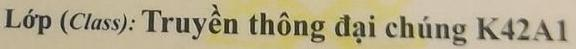

In [34]:
import random
from IPython.display import display

def show_random_rec_sample(label_path, img_root):
    with open(label_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    line = random.choice(lines)
    path, text = line.rstrip("\n").split("\t")
    img_path = os.path.join(OUTPUT_ROOT_REC, path)
    print("Ảnh:", img_path)
    print("Text:", text)
    img = Image.open(img_path).convert("RGB")
    display(img)

show_random_rec_sample(train_label_rec, train_img_root_rec)
